# Percepción del Consumidor y An ́alisis de Sentimientos en Reseñas de E-Commerce

En este cuaderno realizaremos un análisis de sentimientos en Python utilizando dos técnicas diferentes:

1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Enfoque de bolsa de palabras
2. Modelo preentrenado RoBERTa de HuggingFace

Integrantes: 

- Calvillo Martínez Erik
- De La Cruz Munguia Arely 
- Olguín Ramírez Azul Yunuen
- Sánchez Pérez Marco Antonio
- Vázquez Pérez Karla 

# Paso 1. Lectura del Corpus y conceptos básicos de NLTK

### Importando librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

### Accediendo al corpus

In [15]:
#Read in data
df = pd.read_csv('Reviews_shuffled.csv')
print(df.shape)
df = df.head(30000)
print(df.shape)


(318454, 10)
(30000, 10)


In [16]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,230934,B001EQ4KM8,A1Q9YNC9O19SMK,mr_dogbert,0,0,4,1314403200,Excellent quality and value for money,Great worms and a great value for money. A bit...
1,277064,B001LQNXOC,AT4UDNMEUC52C,Silvia Torre,4,4,4,1316822400,Good coffee,I did like the coffee but unfortunately the po...
2,467886,B000EVOQNC,A2EZMTILEYA9GA,D. Ulm,0,0,5,1231632000,Great Buy!!!! Great Licorice!!!!,Best licorice (since the original Switzers). ...
3,449551,B003P9WU6K,A1X3JBFQ5H2RBH,JennR,0,0,2,1348790400,Grocery store cat food ingredients!!,I ordered this due to waiting for my reg brand...
4,527179,B000LKTBA4,A1NFSGHFUATGD5,Boris & Natasha,7,7,4,1211414400,"Great, once you get used to the texture....",Quinoa pasta is great. It just takes a bit lon...


## Quick EDA

Recuento de reseñas según el número de estrellas

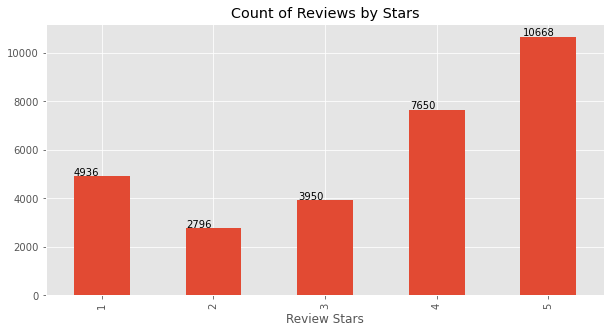

In [17]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.show()

## Basic NLTK

Ejemplos del uso de nltk

In [55]:
example = df['Text'][28000]
print(example)

This olive oil is supposed to be special.  I don't taste anything special.  To me, it tastes slightly better than normal, cheap, off the grocery store shelf olive oil.  I got mine at a local Italian grocery store for the same price as what's listed here.  Not worth it if you ask me.<br /><br />Google Frantoio for olive oil that has a nice taste.


In [13]:
tokens = nltk.word_tokenize(example)
tokens[:20]

['I',
 'know',
 'this',
 'is',
 'a',
 'great',
 'product',
 '.',
 'My',
 'chiropractor',
 'puts',
 'it',
 'on',
 'her',
 'toast',
 '!',
 'You',
 'can',
 'also',
 'mix']

In [14]:
tagged = nltk.pos_tag(tokens)
tagged[:20]

[('I', 'PRP'),
 ('know', 'VBP'),
 ('this', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('great', 'JJ'),
 ('product', 'NN'),
 ('.', '.'),
 ('My', 'PRP$'),
 ('chiropractor', 'NN'),
 ('puts', 'VBZ'),
 ('it', 'PRP'),
 ('on', 'IN'),
 ('her', 'PRP'),
 ('toast', 'NN'),
 ('!', '.'),
 ('You', 'PRP'),
 ('can', 'MD'),
 ('also', 'RB'),
 ('mix', 'VB')]

In [18]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  know/VBP
  this/DT
  is/VBZ
  a/DT
  great/JJ
  product/NN
  ./.
  My/PRP$
  chiropractor/NN
  puts/VBZ
  it/PRP
  on/IN
  her/PRP
  toast/NN
  !/.
  You/PRP
  can/MD
  also/RB
  mix/VB
  it/PRP
  with/IN
  strawberry/JJ
  jam/NN
  and/CC
  use/VB
  it/PRP
  on/IN
  toast/NN
  ./.
  It/PRP
  works/VBZ
  extremely/RB
  well/RB
  as/IN
  a/DT
  hand/NN
  cream/NN
  ,/,
  but/CC
  it/PRP
  is/VBZ
  hard/JJ
  and/CC
  not/RB
  creamy/VB
  until/IN
  you/PRP
  warm/VBP
  it/PRP
  up/RP
  ./.)


# Paso 1. Puntuación de Sentimiento VADER

Utilizaremos el SentimentIntensityAnalyzer de NLTK para obtener las puntuaciones negativas, neutrales y positivas del texto.

- Esto utiliza un enfoque de "bolsa de palabras":
    1. Se eliminan las palabras vacías.
    2. Cada palabra se puntúa y se combina en una puntuación total.

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [20]:
sia.polarity_scores('I am really happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [21]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [22]:
sia.polarity_scores(example)

{'neg': 0.032, 'neu': 0.784, 'pos': 0.183, 'compound': 0.7594}

In [23]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [24]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [25]:
# Now we have sentiment score and metadata
#vaders.head()
from IPython.display import display

# Mostrar un número específico de filas
display(vaders.head(100))



,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,230934,0.000,0.652,0.348,0.9565,B001EQ4KM8,A1Q9YNC9O19SMK,mr_dogbert,0,0,4,1314403200,Excellent quality and value for money,Great worms and a great value for money. A bit...
1,277064,0.203,0.756,0.040,-0.7978,B001LQNXOC,AT4UDNMEUC52C,Silvia Torre,4,4,4,1316822400,Good coffee,I did like the coffee but unfortunately the po...
2,467886,0.000,0.437,0.563,0.9169,B000EVOQNC,A2EZMTILEYA9GA,D. Ulm,0,0,5,1231632000,Great Buy!!!! Great Licorice!!!!,Best licorice (since the original Switzers). ...
3,449551,0.075,0.737,0.188,0.9140,B003P9WU6K,A1X3JBFQ5H2RBH,JennR,0,0,2,1348790400,Grocery store cat food ingredients!!,I ordered this due to waiting for my reg brand...
4,527179,0.070,0.791,0.139,0.4926,B000LKTBA4,A1NFSGHFUATGD5,Boris & Natasha,7,7,4,1211414400,"Great, once you get used to the texture....",Quinoa pasta is great. It just takes a bit lon...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,560810,0.000,0.879,0.121,0.8773,B001I7HSWM,ACQFLKC14RNPL,wildkat,0,0,5,1298073600,Really good herbal tea,I took a chance on this tea since I couldn't h...
96,458909,0.000,0.697,0.303,0.9116,B000LKYZDW,A30N1DB2QKVEOE,Dimasin,2,2,3,1229644800,Great snack full of FAT,Really great snack when you wish something dif...
97,485767,0.034,0.928,0.038,0.0516,B001RVFERK,A1B2UXUU1H9CPT,"K. Haught ""ArLo""",0,5,2,1279238400,Not so good,After doing numerous googles looking for Chips...
98,444265,0.105,0.852,0.043,-0.5170,B000LKZ0R2,A2YE8COR2PUTZW,D. Darby,4,4,5,1299369600,Yummy as ever but smashed to smithereens...,We LOVE these chips - they are addictive. Onl...


## Plot VADER results

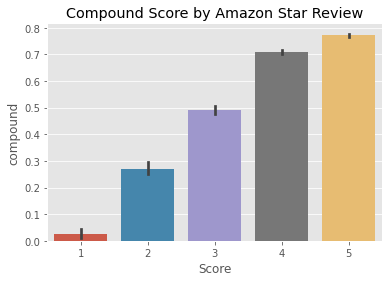

In [26]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

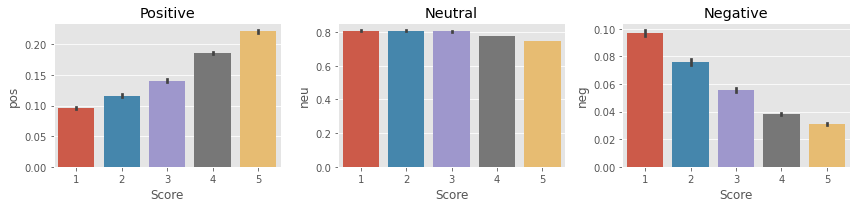

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Paso 2. Modelo preentrenado RoBERTa

- Utilizar un modelo entrenado con un gran corpus de datos.
- El modelo de transformador tiene en cuenta las palabras, pero también el contexto relacionado con otras palabras.

In [28]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [29]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [30]:
# VADER results on example
print(example)
sia.polarity_scores(example)

I know this is a great product. My chiropractor puts it on her toast!  You can also mix it with strawberry jam and use it on toast. It works extremely well as a hand cream, but it is hard and not creamy until you warm it up.


{'neg': 0.032, 'neu': 0.784, 'pos': 0.183, 'compound': 0.7594}

In [31]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0021398645, 'roberta_neu': 0.025675993, 'roberta_pos': 0.972184}


In [32]:
def polarity_scores_roberta(example, max_length=512):
    encoded_text = tokenizer(example, truncation=True, max_length=max_length, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict


In [33]:
# Iterar sobre el DataFrame y calcular las puntuaciones de RoBERTa
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

# Crear un DataFrame con los resultados de RoBERTa
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# Imprimir o guardar el DataFrame
print(results_df.head())
results_df.to_csv('roberta_sentiment_results.csv', index=False)

  0%|          | 0/30000 [00:00<?, ?it/s]

       Id  roberta_neg  roberta_neu  roberta_pos   ProductId          UserId  \
0  230934     0.010350     0.042706     0.946944  B001EQ4KM8  A1Q9YNC9O19SMK   
1  277064     0.755045     0.212540     0.032415  B001LQNXOC   AT4UDNMEUC52C   
2  467886     0.001879     0.033033     0.965088  B000EVOQNC  A2EZMTILEYA9GA   
3  449551     0.767727     0.175125     0.057148  B003P9WU6K  A1X3JBFQ5H2RBH   
4  527179     0.076379     0.272278     0.651343  B000LKTBA4  A1NFSGHFUATGD5   

       ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0       mr_dogbert                     0                       0      4   
1     Silvia Torre                     4                       4      4   
2           D. Ulm                     0                       0      5   
3            JennR                     0                       0      2   
4  Boris & Natasha                     7                       7      4   

         Time                                      Summary  \
0  131

## Comparación de scores entre modelos

In [36]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Step 3. Combine and compare

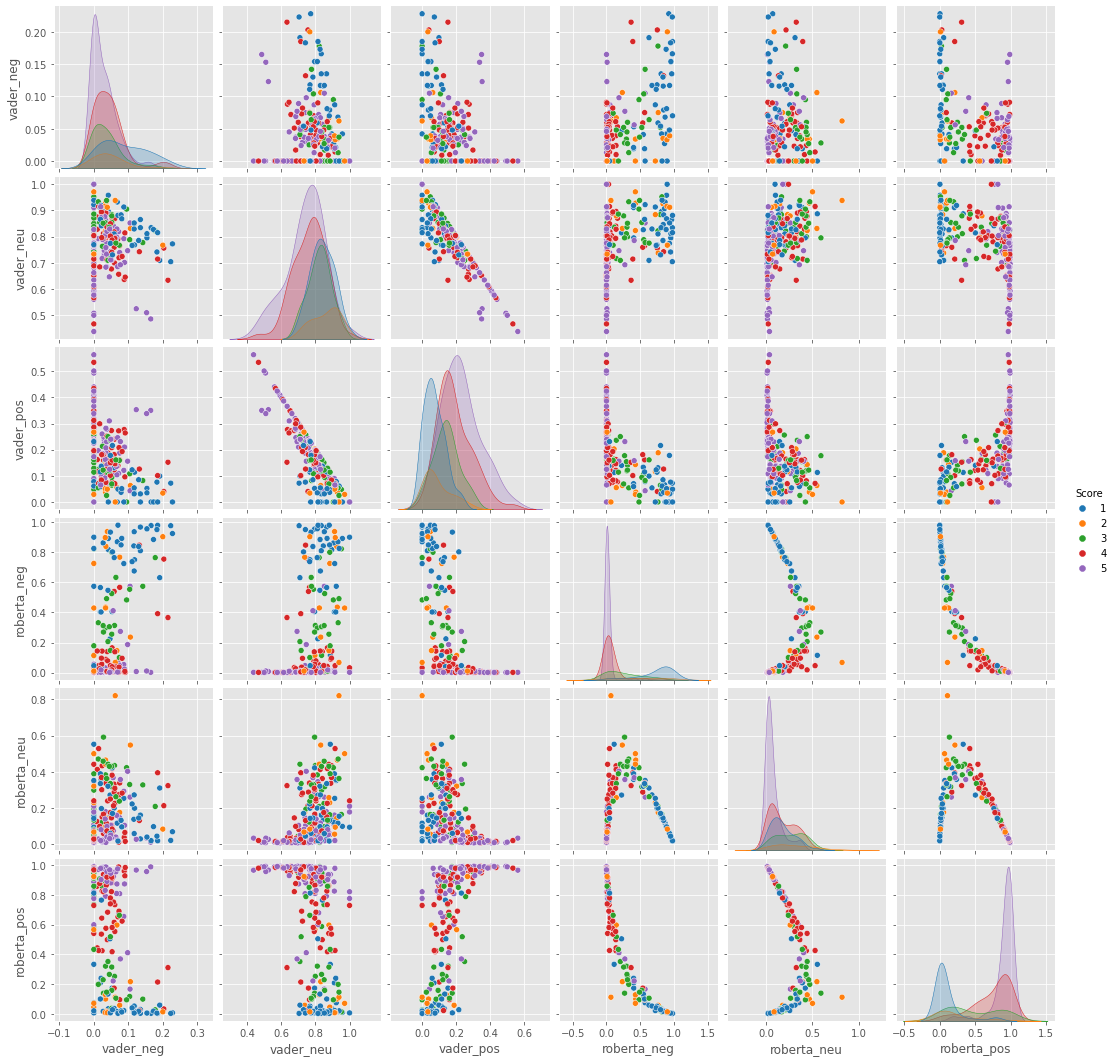

In [37]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [38]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"The best price you're going to find anywhere right now is at Costco, a 24 pack costs $32.99 with $7 off PLUS TAX and CRV.<br />Don't over pay for that!!!!!!!!!!!!!<br />RED BULL IS AN EXPENSIVE ENOUGH HABIT! LOL."

In [39]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

"The best price you're going to find anywhere right now is at Costco, a 24 pack costs $32.99 with $7 off PLUS TAX and CRV.<br />Don't over pay for that!!!!!!!!!!!!!<br />RED BULL IS AN EXPENSIVE ENOUGH HABIT! LOL."

In [40]:
# nevative sentiment 5-Star view

In [41]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

"We LOVE these chips - they are addictive.  Only thing wrong with this shipment is that they crammed all 24 bags into a small box and smushed a lot of them in the process...We don't care most of the time - It all tastes the same to us - but really - I t makes you feel a little neandethral when trying to eat them and does not look pretty in a bowl..."

In [42]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'Fantastic taste, smooth "feel", no nasty aftertaste, pairs great with creamer. What more can one want from a coffee? This has become my favorite.'

# Evaluation

+-----------+----------+-----------+----------------+
| Metric    |    VADER |   RoBERTa | Better Model   |
+===========+==========+===========+================+
| Accuracy  | 0.848485 |  0.87013  | RoBERTa        |
+-----------+----------+-----------+----------------+
| Precision | 0.865979 |  0.95092  | RoBERTa        |
+-----------+----------+-----------+----------------+
| Recall    | 0.949153 |  0.875706 | VADER          |
+-----------+----------+-----------+----------------+
| F1 Score  | 0.90566  |  0.911765 | RoBERTa        |
+-----------+----------+-----------+----------------+
| ROC-AUC   | 0.733836 |  0.863779 | RoBERTa        |
+-----------+----------+-----------+----------------+

Estimaciones de complejidad temporal:
VADER: O(n), Time: 0.0000s
RoBERTa: O(n^2), Time: 0.0050s


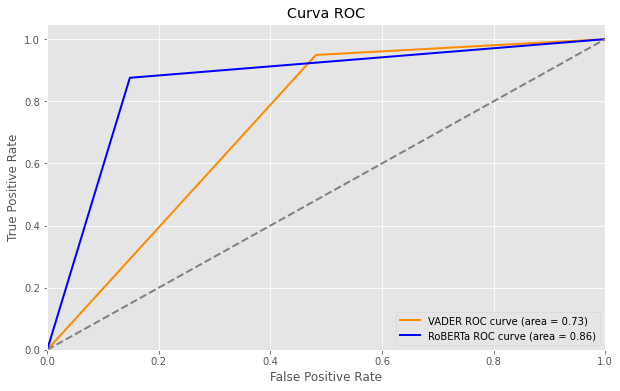

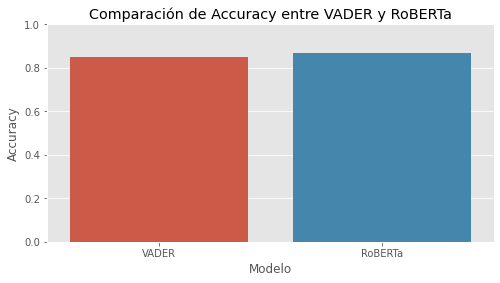

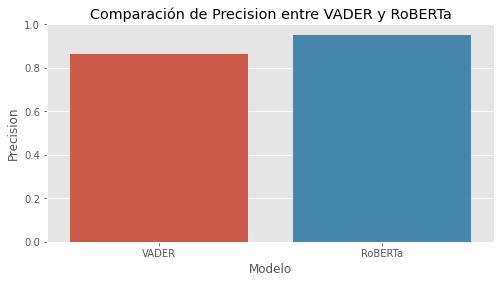

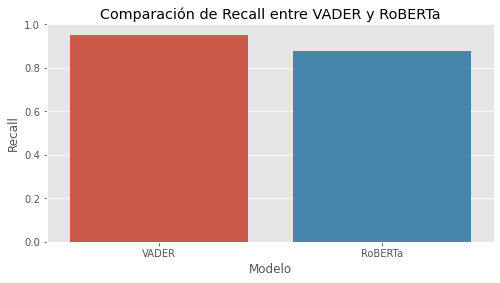

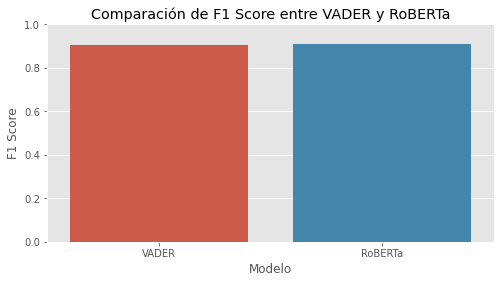

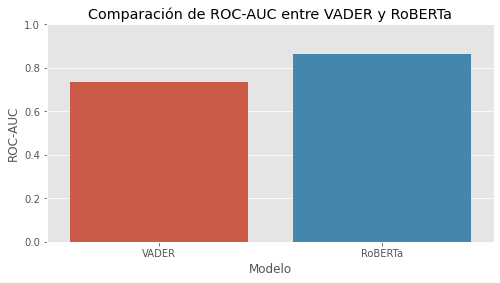

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from tabulate import tabulate
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Función para obtener etiquetas binarias verdaderas
def get_true_labels(df, score_column='Score', threshold=3):
    return df[score_column].apply(lambda x: 1 if x >= threshold else 0)

# Función para obtener predicciones binarias para VADER
def get_vader_predictions(df, compound_column='vader_compound'):
    return df.apply(lambda row: 1 if row[compound_column] >= 0 else 0, axis=1)

# Función para obtener predicciones binarias para RoBERTa
def get_roberta_predictions(df, pos_column='roberta_pos', neg_column='roberta_neg'):
    return df.apply(lambda row: 1 if row[pos_column] > row[neg_column] else 0, axis=1)

# Función para medir el tiempo de procesamiento
def measure_time(func):
    start_time = time.time()
    func()
    end_time = time.time()
    return end_time - start_time

# Funciones de procesamiento
def process_vader():
    results_df.apply(lambda row: 1 if row['vader_compound'] >= 0 else 0, axis=1)

def process_roberta():
    results_df.apply(lambda row: 1 if row['roberta_pos'] > row['roberta_neg'] else 0, axis=1)

# Suponiendo que 'results_df' ya está definido y contiene los datos necesarios

# Obtener etiquetas binarias verdaderas
results_df['true_label'] = get_true_labels(results_df)
true_labels = results_df['true_label']

# Obtener predicciones binarias
results_df['vader_pred'] = get_vader_predictions(results_df)
vader_pred = results_df['vader_pred']

results_df['roberta_pred'] = get_roberta_predictions(results_df)
roberta_pred = results_df['roberta_pred']

# Calcular métricas para VADER
metrics_vader = {
    'Accuracy': accuracy_score(true_labels, vader_pred),
    'Precision': precision_score(true_labels, vader_pred, average='binary'),
    'Recall': recall_score(true_labels, vader_pred, average='binary'),
    'F1 Score': f1_score(true_labels, vader_pred, average='binary'),
    'ROC-AUC': roc_auc_score(true_labels, vader_pred)
}

# Calcular métricas para RoBERTa
metrics_roberta = {
    'Accuracy': accuracy_score(true_labels, roberta_pred),
    'Precision': precision_score(true_labels, roberta_pred, average='binary'),
    'Recall': recall_score(true_labels, roberta_pred, average='binary'),
    'F1 Score': f1_score(true_labels, roberta_pred, average='binary'),
    'ROC-AUC': roc_auc_score(true_labels, roberta_pred)
}

# Medir tiempos de procesamiento
vader_time = measure_time(process_vader)
roberta_time = measure_time(process_roberta)

# Estimaciones de complejidad temporal
complexity_estimates = {
    'VADER': f'O(n), Time: {vader_time:.4f}s',
    'RoBERTa': f'O(n^2), Time: {roberta_time:.4f}s'
}

# Crear un DataFrame para la presentación de métricas
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'VADER': [metrics_vader['Accuracy'], metrics_vader['Precision'], metrics_vader['Recall'], metrics_vader['F1 Score'], metrics_vader['ROC-AUC']],
    'RoBERTa': [metrics_roberta['Accuracy'], metrics_roberta['Precision'], metrics_roberta['Recall'], metrics_roberta['F1 Score'], metrics_roberta['ROC-AUC']]
})

# Determinar el mejor modelo para cada métrica
metrics_df['Better Model'] = metrics_df.apply(lambda row: 'VADER' if row['VADER'] > row['RoBERTa'] else 'RoBERTa', axis=1)

# Mostrar resultados en una tabla con líneas
print(tabulate(metrics_df, headers='keys', tablefmt='grid', showindex=False))

# Mostrar estimaciones de complejidad
print("\nEstimaciones de complejidad temporal:")
for model, complexity in complexity_estimates.items():
    print(f"{model}: {complexity}")

# Graficar la curva ROC
fpr_vader, tpr_vader, _ = roc_curve(true_labels, results_df['vader_pred'])
roc_auc_vader = auc(fpr_vader, tpr_vader)

fpr_roberta, tpr_roberta, _ = roc_curve(true_labels, results_df['roberta_pred'])
roc_auc_roberta = auc(fpr_roberta, tpr_roberta)

plt.figure(figsize=(10, 6))
plt.plot(fpr_vader, tpr_vader, color='darkorange', lw=2, label=f'VADER ROC curve (area = {roc_auc_vader:.2f})')
plt.plot(fpr_roberta, tpr_roberta, color='blue', lw=2, label=f'RoBERTa ROC curve (area = {roc_auc_roberta:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Graficar cada métrica por separado
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
melted_df = metrics_df.melt(id_vars='Metric', value_vars=['VADER', 'RoBERTa'], var_name='Model', value_name='Value')

for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Model', y='Value', data=melted_df[melted_df['Metric'] == metric])
    plt.title(f'Comparación de {metric} entre VADER y RoBERTa')
    plt.ylabel(metric)
    plt.xlabel('Modelo')
    plt.ylim(0, 1)
    plt.show()
